In [1]:
from dataset.dataset import NERDataset
from torch.utils.data import DataLoader
import numpy as np
from typing import Sequence, List, Tuple

train_data = NERDataset(tokenizer="spacy", cased=False, mode='train')
test_data = NERDataset(tokenizer="spacy", cased=False, mode='test')
val_data = NERDataset(tokenizer="spacy", cased=False, mode='valid')

## 1. Main train loop


In [7]:
import torch.optim as optim
import torch.nn as nn
import torch
from models.transformerTagger import TransformerTagger
from models.transformerTagger import PositionalEncoder
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch
import datetime as dt
from torch.utils.tensorboard import SummaryWriter
from torchmetrics import F1Score, Accuracy, Precision, Recall
import utils
import time


TODAY = dt.datetime.today().strftime("%Y-%m-%d")

BATCH_SIZE = 256
BASE_LR = 1e-3
MAX_EPOCHS = 20
RUN_NO = 1
LOG_DIR = "./log/traininglog"
MINIBATCH_SIZE = 16
WRITER = SummaryWriter(log_dir=f"{LOG_DIR}/{TODAY}_runno_{RUN_NO}")
SAVE_EVERY = 5
SAVE_DIR = f"./checkpoint/{TODAY}_runo{RUN_NO}.pt"

f1 = F1Score(num_classes=10, threshold=0.5)
accu = Accuracy(threshold=0.5, num_classes=10)
precision = Precision(num_classes=10)
recall = Recall(num_classes=10, threshold=0.5)

feature_padding_value = train_data._tokenidx.get(train_data.pad_token)
tag_padding_value = train_data._targetidx.get(train_data.pad_token)

def collate_fn(data: Sequence[Tuple], 
    n_classes: int=train_data.ntargets,
    feature_padding_value=feature_padding_value,
    tag_padding_value=tag_padding_value,):
    """:return: features, target_prob, target"""
    features, target_prob, targets = zip(*data)
    features = pad_sequence(features, batch_first=True, padding_value=feature_padding_value)
    targets = pad_sequence(targets, batch_first=True, padding_value=tag_padding_value)
    max_len = targets.shape[1]
    batch_size=targets.shape[0]
    target_prob = utils.pad_target_prob(target_prob, n_classes - 1, max_len, n_classes, batch_size)

    return features.long(), target_prob.to(torch.float64), targets.long()

train_dataloader = DataLoader(train_data, 
    shuffle=True, 
    batch_size=BATCH_SIZE, 
    collate_fn=collate_fn
        )
val_dataloader = DataLoader(test_data, 
    shuffle=True, 
    batch_size=BATCH_SIZE, 
    collate_fn=collate_fn
        )

model = TransformerTagger(d_model=128, 
    n_tags=train_data.ntargets, 
    vocab_size=train_data.vocab_size + 1,
    nhead=8, batch_first=True, no_dense_layers=3)
optimizer = optim.Adam(params=model.parameters(), 
    lr=BASE_LR,
    eps=1e-5,
    betas=(0.9, 0.99))

criterion = nn.CrossEntropyLoss()
start = time.time()

global_step = 0
for epoch in range(MAX_EPOCHS):
    print(f"running epoch {epoch}")
    running_loss = 0.
    model.train()
    for i, data in enumerate(train_dataloader):
        print(f"iter_no{i}")
        optimizer.zero_grad()
        src, tag_prob, tags = data
        pred = model(src, src)
        loss = criterion(pred, tag_prob)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % MINIBATCH_SIZE == MINIBATCH_SIZE - 1:
            print(f"{epoch}, pass{i}; loss={running_loss}")
            global_step += i
            WRITER.add_scalar("train/loss", running_loss, 
                walltime=time.time()-start,
                global_step=global_step)
            running_loss = 0
    print(f"finished epoch {epoch}\n------\n")
    if epoch % SAVE_EVERY == SAVE_EVERY - 1:
        torch.save(model, f=SAVE_DIR)
        model.eval()
        running_loss, running_precision, running_recall, running_f1, running_accu \
            = 0., 0., 0., 0., 0.
        counter = 0.
        for i, data in enumerate(val_dataloader):
            src, tag_prob, tags = data
            pred = model(src, src)
            loss = criterion(pred, tag_prob)
            running_loss += loss.item()
            for j, (pred, truth) in enumerate(zip(pred, tag_prob)):
                running_precision += precision(pred, truth.long()).item()
                running_recall += recall(pred, truth.long()).item()
                running_f1 += f1(pred, truth.long()).item()
                running_accu += accu(pred, truth.long()).item()
                counter += j
        if i % MINIBATCH_SIZE == MINIBATCH_SIZE - 1:
            print(f"{epoch}, pass{i}; validation_loss={running_loss};\nvalidation_precision={running_precision / counter}")
            WRITER.add_scalar("val/loss", running_loss, 
                walltime=time.time()-start,
                global_step=global_step)
            WRITER.add_scaler("val/precision", running_precision / counter,
                walltime=time.time()-start,
                global_step=global_step)
            WRITER.add_scaler("val/recall", running_recall / counter,
                walltime=time.time()-start,
                global_step=global_step)
            WRITER.add_scaler("val/f1", running_f1 / counter,
                walltime=time.time()-start,
                global_step=global_step)
            WRITER.add_scaler("val/accuracy", running_accu / counter,
                walltime=time.time()-start,
                global_step=global_step)
            running_loss, running_precision, running_recall, running_f1, running_accu \
            = 0., 0., 0., 0., 0.
            counter = 0.
        
        


running epoch 0
iter_no0
iter_no1
iter_no2
iter_no3
iter_no4
iter_no5
iter_no6
iter_no7
iter_no8
iter_no9
iter_no10
iter_no11
iter_no12
iter_no13
iter_no14
iter_no15
0, pass15; loss=331.7508690966294
iter_no16
iter_no17
iter_no18
iter_no19
iter_no20
iter_no21
iter_no22
iter_no23
iter_no24
iter_no25
iter_no26
iter_no27
iter_no28
iter_no29
iter_no30
iter_no31
0, pass31; loss=308.79465195694934
iter_no32
iter_no33
iter_no34
iter_no35
iter_no36
iter_no37
iter_no38
iter_no39
iter_no40
iter_no41
iter_no42
iter_no43
iter_no44
iter_no45
iter_no46
iter_no47
0, pass47; loss=323.2895537698641
iter_no48
iter_no49
iter_no50
iter_no51
iter_no52
iter_no53
iter_no54
iter_no55
iter_no56
iter_no57


RuntimeError: shape '[256, 44, 10]' is invalid for input of size 61160

In [31]:
from torchmetrics import F1Score, Accuracy, Precision, Recall
f1 = F1Score(num_classes=10, threshold=0.5)
accu = Accuracy(threshold=0.5, num_classes=10)
precision = Precision(num_classes=10)
recall = Recall(num_classes=10, threshold=0.5)
f1(pred_prob[0], tag_prob[0].long())

tensor(0.)

In [37]:
running_precision = 0
for i, (pred, truth) in enumerate(zip(pred_prob, tag_prob)):
    running_precision += precision(pred, truth.long()).item()

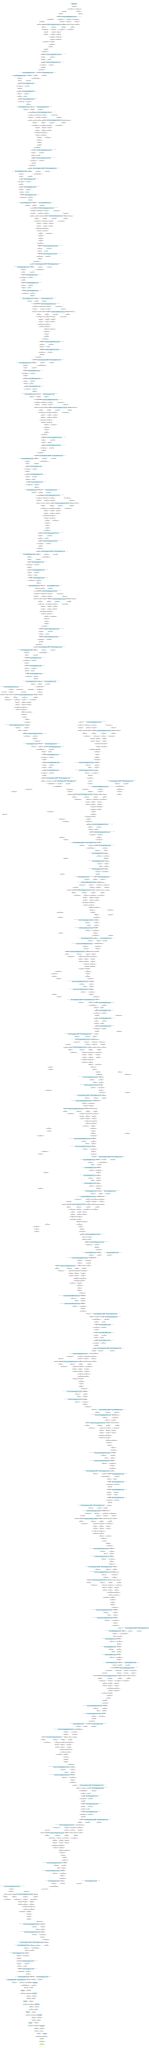

In [19]:
# visualize graph
from torchviz import make_dot
import os
os.environ["PATH"] = os.getenv("PATH") + ":/opt/homebrew/bin:/opt/homebrew/Cellar"
model.requires_grad_()
make_dot(var=out, params=dict(model.named_parameters()))

In [9]:
help(make_dot)

Help on function make_dot in module torchviz.dot:

make_dot(var, params=None, show_attrs=False, show_saved=False, max_attr_chars=50)
    Produces Graphviz representation of PyTorch autograd graph.
    
    If a node represents a backward function, it is gray. Otherwise, the node
    represents a tensor and is either blue, orange, or green:
     - Blue: reachable leaf tensors that requires grad (tensors whose `.grad`
         fields will be populated during `.backward()`)
     - Orange: saved tensors of custom autograd functions as well as those
         saved by built-in backward nodes
     - Green: tensor passed in as outputs
     - Dark green: if any output is a view, we represent its base tensor with
         a dark green node.
    
    Args:
        var: output tensor
        params: dict of (name, tensor) to add names to node that requires grad
        show_attrs: whether to display non-tensor attributes of backward nodes
            (Requires PyTorch version >= 1.9)
        show_